In [ ]:
!nvidia-smi

Tue Nov 30 13:29:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download, ZIP Dataset and remove file not needed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Dataset x-ray prepro negative + gausLowPass/Dataset_preprocessing.zip'

Streaming output truncated to the last 5000 lines.
  inflating: content/Dataset_With_preprocessing/Normal/Normal-2134.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-3751.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-9873.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-4154.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-224.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-10165.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-1652.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-5426.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-7733.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-9333.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-3137.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-7445.png  
  inflating: content/Dataset_With_preprocessing/Normal/Normal-3926.png  


In [ ]:
import os
os.listdir('/content/content/Dataset_With_preprocessing')

['Viral Pneumonia', 'COVID', 'Normal']

# Divide dataset into train and val

In [ ]:
!pip install split-folders

In [ ]:
# import splitfolders

# folder = '/content/Dataset_Without_preprocessing'

# splitfolders.ratio(folder, output='/content/Dataset_WithoutPre_split',
#                  seed=42, ratio=(0.8, 0.2),
#                  group_prefix = None
#                  )

In [ ]:
import splitfolders

folder = '/content/content/Dataset_With_preprocessing'

splitfolders.ratio(folder, output='/content/Dataset_WithPre_split',
                 seed=42, ratio=(0.8, 0.2),
                 group_prefix = None
                 )

Copying files: 15153 files [00:04, 3447.56 files/s]


# Model CNN + Plot + Confussion matrix with preprocessing

In [ ]:
train_dir = '/content/Dataset_WithPre_split/train'
val_dir = '/content/Dataset_WithPre_split/val'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest',
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(170, 170),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    # seed=123,
    ) # set as training data
validation_generator = val_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(170, 170),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False,
    )

Found 12121 images belonging to 3 classes.
Found 3032 images belonging to 3 classes.


In [ ]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(170,170,1)),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, (3,3), padding='same',  activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 170, 170, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 170, 170, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                    

In [ ]:
# callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
checkpoint_filepath = '/content/checkpoint'
model_2_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
optimizer_2 = tf.optimizers.Adamax(learning_rate=1e-3, epsilon=1e-05)
model_2.compile(optimizer=optimizer_2,
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

history_2 = model_2.fit(train_generator,
                    steps_per_epoch= 12121 // 64,
                    validation_data=validation_generator,
                    validation_steps= 3032 // 64,
                    epochs=100,
                    callbacks=[model_2_checkpoint_callback],
                    verbose=1
                  )

Epoch 1/100
189/189 [==============================] - 78s 352ms/step - loss: 0.7976 - accuracy: 0.6532 - val_loss: 0.8203 - val_accuracy: 0.6779
Epoch 2/100
189/189 [==============================] - 65s 343ms/step - loss: 0.7097 - accuracy: 0.6713 - val_loss: 0.6696 - val_accuracy: 0.7297
Epoch 3/100
189/189 [==============================] - 64s 340ms/step - loss: 0.6329 - accuracy: 0.6962 - val_loss: 0.5574 - val_accuracy: 0.7753
Epoch 4/100
189/189 [==============================] - 64s 340ms/step - loss: 0.5872 - accuracy: 0.7290 - val_loss: 0.5376 - val_accuracy: 0.7969
Epoch 5/100
189/189 [==============================] - 65s 343ms/step - loss: 0.5510 - accuracy: 0.7550 - val_loss: 0.4597 - val_accuracy: 0.8195
Epoch 6/100
189/189 [==============================] - 65s 344ms/step - loss: 0.5226 - accuracy: 0.7669 - val_loss: 0.4576 - val_accuracy: 0.8275
Epoch 7/100
189/189 [==============================] - 65s 342ms/step - loss: 0.4957 - accuracy: 0.7861 - val_loss: 0.4100 -

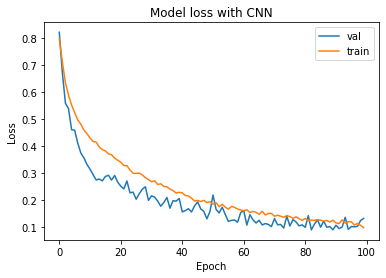

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_2.history['val_loss'])
plt.plot(history_2.history['loss'])
plt.title('Model loss with CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val', 'train'], loc='upper right')
plt.show()

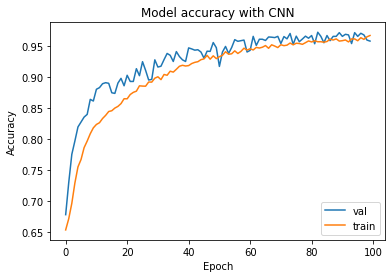

In [ ]:
plt.plot(history_2.history['val_accuracy'])
plt.plot(history_2.history['accuracy'])
plt.title('Model accuracy with CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['val', 'train'], loc='lower right')
plt.show()

In [ ]:
model_2.evaluate(train_generator)

190/190 [==============================] - 50s 263ms/step - loss: 0.1141 - accuracy: 0.9559


[0.11411406099796295, 0.9559442400932312]

In [ ]:
model_2.evaluate(validation_generator)

48/48 [==============================] - 6s 133ms/step - loss: 0.1343 - accuracy: 0.9575


[0.13429749011993408, 0.9574538469314575]

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

validation_generator.reset()
Y_pred = model_2.predict_generator(validation_generator, 3032 // 64+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cf_mtx = confusion_matrix(validation_generator.classes, y_pred)
print(cf_mtx)
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Confusion Matrix
[[ 646   73    5]
 [  23 2007    9]
 [   1   18  250]]
Classification Report
                 precision    recall  f1-score   support

          COVID       0.96      0.89      0.93       724
         Normal       0.96      0.98      0.97      2039
Viral Pneumonia       0.95      0.93      0.94       269

       accuracy                           0.96      3032
      macro avg       0.96      0.94      0.95      3032
   weighted avg       0.96      0.96      0.96      3032



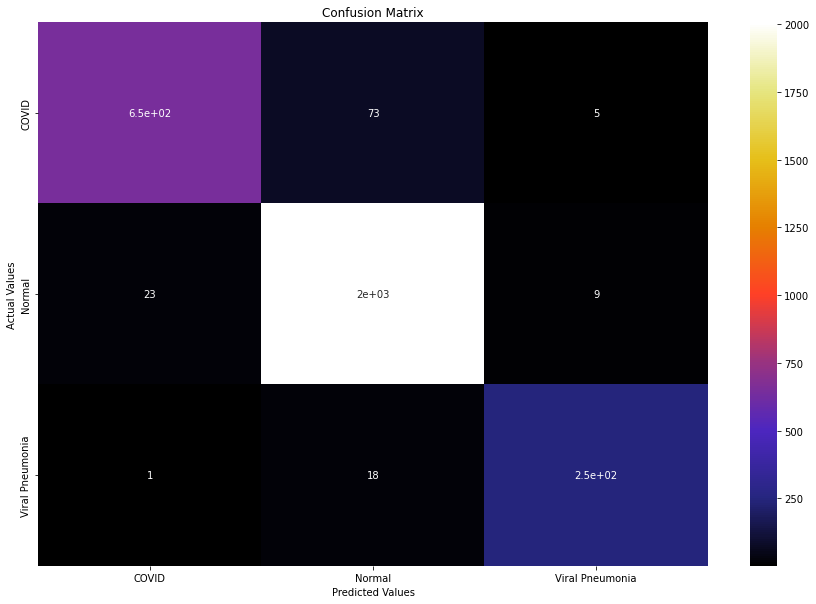

In [ ]:
import pandas as pd
import seaborn as sns

cm_df = pd.DataFrame(cf_mtx,
                     index=target_names,
                     columns=target_names)

plt.figure(figsize=(15,10))
sns.heatmap(cm_df, annot=True, cmap='CMRmap')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
model_2.save('modelAdamax.h5')